In [166]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [167]:
!python -m nltk.downloader punkt

/Users/t.k/opt/anaconda3/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /Users/t.k/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [168]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[2].lstrip().rstrip()
            text = cols[3]

            X.append(text)
            Y.append(label)

    return X, Y

In [200]:
class Classifier:

    def __init__(self, feature_method, min_feature_count, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count = min_feature_count
        self.log_reg = None

        self.trainY = trainY
        self.devY = devY
        self.testY = testY
        
        self.raw_train = trainX
        self.raw_dev = devX
        self.raw_test = testX
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, class_weight='balanced', max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

            print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))
            
        self.log_reg=best_model
        
        # save prediction
        self.train_pred = self.log_reg.predict(self.trainX)
        self.dev_pred = self.log_reg.predict(self.devX)
        

    def test(self):
        
        # save prediction
        self.test_pred = self.log_reg.predict(self.testX)
        self.test_prob = self.log_reg.predict_proba(self.testX)
        
        # classify test examples into TP, TN, FP, FN along with probability
        TP, TN, FP, FN = [], [], [], []
        for i in range(len(self.test_pred)):
            # True Positive
            if self.testY[i] == 'pos' and self.test_prob[i][0] >= 0.5:
                TP.append((self.test_prob[i][0], self.raw_test[i]))
            # True Negative
            elif self.testY[i] == 'neg' and self.test_prob[i][0] < 0.5:
                TN.append((self.test_prob[i][0], self.raw_test[i]))
            # False Positive
            elif self.testY[i] == 'neg' and self.test_prob[i][0] >= 0.5:
                FP.append((self.test_prob[i][0], self.raw_test[i]))
            # False Negative
            else:
                FN.append((self.test_prob[i][0], self.raw_test[i]))
        
        # sort each by probability
        TP.sort(reverse=True)
        TN.sort()
        FP.sort(reverse=True)
        FN.sort()
        
        self.TP, self.TN, self.FP, self.FN = np.array(TP), np.array(TN), np.array(FP), np.array(FN) 
        
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()
            

    # Plot confusion matrix on test data
    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.testY, self.test_pred, normalize="all")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.log_reg.classes_)
        disp.plot()
        
        
    # Print wrong examples with the most gap between true label and prediction
    def print_wrong_examples(self, n=3):
        
        # FP
        print("False Positives (Predicted POS & True NEG)\n")
        for i in range(n):
            print(f"Probablity: {self.FP[i][0]}")
            print(self.FP[i][1], end="\n")
            
        # FN
        print("\nFalse Negatives (Predicted NEG & True POS)\n")
        for i in range(n):
            print(f"Probablity: {self.FN[i][0]}")
            print(self.FN[i][1])
        
        
    #def get_params(self, word):
        #return self.log

In [201]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [202]:
def run(trainingFile, devFile, testFile, feature_method, min_feature_count):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(feature_method, min_feature_count, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights(n=20)
    
    return simple_classifier

In [218]:
# preprocessing 
# 1. lower
# 2. remove stop words
# 3. convert number to same value

def custom_featurize(text):
    remove_words = ["around", "make", "endive", "still", ":"] # not stop words but almost meaningless
    stop_words = set(stopwords.words('english'))
    feats = {}
    
    # word_length
    feats['num_tokens'] = len(text.split())
    
    # tokenize
    words = nltk.word_tokenize(text)
            
    for word in words:
        # remove stopwords and custom words and ingredients name
        if word in stop_words or word in remove_words:
            continue
        
        # convert to lowercase
        word = word.lower()
        
        # seperate temperature number and degree
        if "°" in word:
            word = word[:-2]
            feats["°F"] = 1

        # convert numbers to 'num_symbol'
        word = 'num_symbol' if any([char.isdigit() for char in word]) else word
            
        feats[word] = 1
    
    return feats

In [222]:
trainingFile = "train.txt"
devFile = "dev.txt"
testFile = "test.txt"
    
model = run(trainingFile, devFile, testFile, custom_featurize, min_feature_count=4)

C: 0.1, Train accuracy: 0.930, Dev accuracy: 0.770
C: 1, Train accuracy: 1.000, Dev accuracy: 0.810
C: 10, Train accuracy: 1.000, Dev accuracy: 0.790
C: 100, Train accuracy: 1.000, Dev accuracy: 0.780
Test accuracy for best dev model: 0.770, 95% CIs: [0.688 0.852]

pos	0.678	tablespoons
pos	0.668	toast
pos	0.609	mustard
pos	0.583	broth
pos	0.576	prepared
pos	0.557	medium-high
pos	0.554	foil
pos	0.548	ice
pos	0.548	cut
pos	0.540	celery
pos	0.538	glass
pos	0.525	put
pos	0.514	chop
pos	0.513	dish
pos	0.492	preheat
pos	0.491	place
pos	0.487	divide
pos	0.479	topped
pos	0.468	cover
pos	0.464	leaving

neg	-0.875	season
neg	-0.765	warm
neg	-0.695	powder
neg	-0.695	soda
neg	-0.679	hour
neg	-0.621	bell
neg	-0.610	garlic
neg	-0.598	often
neg	-0.590	parmesan
neg	-0.578	paprika
neg	-0.572	medium-low
neg	-0.545	recipe
neg	-0.545	vinegar
neg	-0.525	frozen
neg	-0.519	liquid
neg	-0.509	club
neg	-0.506	serving
neg	-0.500	mixture
neg	-0.494	milk
neg	-0.489	baking



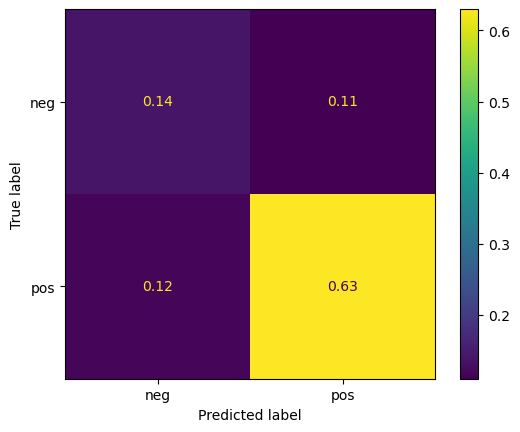

In [223]:
model.plot_confusion_matrix()

In [225]:
model.print_wrong_examples()

False Positives (Predicted POS & True NEG)

Probablity: 0.9878246863595536
Mix giardiniera into mayonnaise in a small bowl. Thickly spread some giardiniera mixture over the bottom half of each roll. Top each with tomato slices; season with salt. Layer on a thick tuft of shredded lettuce; season lettuce with salt, pepper, and a splash of reserved giardiniera brine (about 1 Tbsp. per sandwich). Drizzle with oil.

Probablity: 0.8981984710008067
Combine lemon zest, lemon juice, arugula, beans, capers, red pepper flakes, 1/4 cup oil, and 1/2 tsp. salt in a large bowl. Cook campanelle in a large pot of boiling salted water, stirring occasionally, until al dente. Drain pasta, reserving 1 cup pasta cooking liquid, and add to bean mixture. Stir vigorously and add pasta cooking liquid as needed to fully coat. Season with salt. Transfer pasta to a serving bowl or platter. Using your hands, tear burrata over pasta and drizzle with more oil. Serve immediately.

Probablity: 0.8912568019747691
Bring 

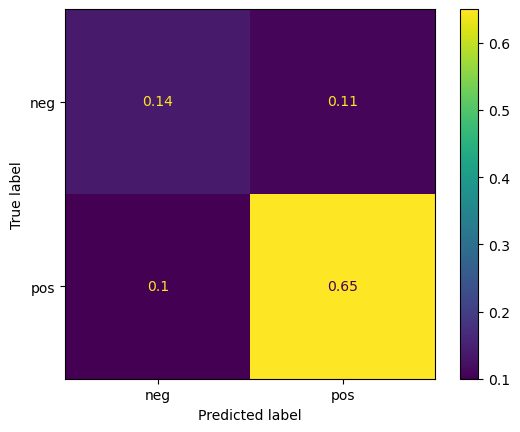

In [98]:
custom_model = run(trainingFile, devFile, testFile, custom_featurize)

C: 0.1, Train accuracy: 0.943, Dev accuracy: 0.770
C: 1, Train accuracy: 1.000, Dev accuracy: 0.800
C: 10, Train accuracy: 1.000, Dev accuracy: 0.760
C: 100, Train accuracy: 1.000, Dev accuracy: 0.750
Test accuracy for best dev model: 0.780, 95% CIs: [0.699 0.861]

pos	0.588	tablespoons
pos	0.563	endive
pos	0.546	3/4
pos	0.545	toast
pos	0.531	broth
pos	0.517	glass
pos	0.516	still
pos	0.500	prepared
pos	0.499	mustard
pos	0.487	place

neg	-0.788	season
neg	-0.666	warm
neg	-0.656	soda
neg	-0.655	powder
neg	-0.589	hour
neg	-0.570	parmesan
neg	-0.557	garlic
neg	-0.533	bell
neg	-0.527	paprika
neg	-0.513	450°f



In [99]:
custom_model.print_wrong_examples()

False Positives (Predicted POS & True NEG)

Probablity: 0.979874125892744
Mix giardiniera into mayonnaise in a small bowl. Thickly spread some giardiniera mixture over the bottom half of each roll. Top each with tomato slices; season with salt. Layer on a thick tuft of shredded lettuce; season lettuce with salt, pepper, and a splash of reserved giardiniera brine (about 1 Tbsp. per sandwich). Drizzle with oil.

Probablity: 0.9093998372091239
Combine lemon zest, lemon juice, arugula, beans, capers, red pepper flakes, 1/4 cup oil, and 1/2 tsp. salt in a large bowl. Cook campanelle in a large pot of boiling salted water, stirring occasionally, until al dente. Drain pasta, reserving 1 cup pasta cooking liquid, and add to bean mixture. Stir vigorously and add pasta cooking liquid as needed to fully coat. Season with salt. Transfer pasta to a serving bowl or platter. Using your hands, tear burrata over pasta and drizzle with more oil. Serve immediately.

Probablity: 0.8341144291310166
To make

array([], dtype=float64)

## b) Analysis

Ideas:
- Confusion matrix
- Look at Wrong Examples